# some novel applications and what FastAI can help us.

### We survived !!! and hopefully learning something in this "walkthrough", now we can explore some new paths as "NG+".

### First a really cool thing called Super Resolution:

Single image super-resolution (SR), which aims atrecovering a high-resolution image from a single low-resolution image, is a classical problem in computervision.
- The problem was first discussed in 1991 [Irani,  M.,  Peleg,  S.:  Improving  resolution  by  image  registration.]
- The use ov CNN was proposed in 2015 [arXiv:1501.00092]
- and in 2016 with gan: arXiv:1609.04802

## The key idea is to have a High quality image (low noise) and the same image but really bad (high noise) and we will train a CNN to "learn" what are the important stuff and what is just garbage.

lets start, first import what we need:

In [1]:
from fastai.vision.all import *
from fastai.data.external import untar_data,URLs
from fastai.data.transforms import get_image_files
import PIL
import torch
import numpy as np
from torch.utils.data import Dataset

In [2]:
path = Path('../super resolution GW/data images/')
path_good = path/'pure'
path_crap = path/'poluted'

In [3]:
path_good.ls()

(#1917) [Path('../super resolution GW/data images/pure/1683_28.6_29.4_1040_2.8501_3.9387_2.3146_0.1378.png'),Path('../super resolution GW/data images/pure/568_23.7_26.6_1267_1.8053_0.3795_1.1448_5.1481.png'),Path('../super resolution GW/data images/pure/631_12.9_24.0_675_0.9939_5.5104_-1.0867_0.0284.png'),Path('../super resolution GW/data images/pure/1264_25.4_28.8_1220_3.9120_3.3674_2.1049_2.9906.png'),Path('../super resolution GW/data images/pure/1720_17.3_30.0_976_2.9096_5.5033_1.7516_6.0552.png'),Path('../super resolution GW/data images/pure/155_10.6_14.5_882_1.5473_4.7927_0.1989_5.3006.png'),Path('../super resolution GW/data images/pure/1680_29.0_29.8_949_4.7024_5.7664_-0.3237_4.1441.png'),Path('../super resolution GW/data images/pure/1020_21.9_28.9_797_0.3585_2.2584_0.7214_5.7837.png'),Path('../super resolution GW/data images/pure/1703_16.4_26.5_1313_6.2189_4.2746_0.6309_5.0874.png'),Path('../super resolution GW/data images/pure/746_6.1_19.5_813_2.6525_1.8140_0.2392_3.6381.png').

In [4]:
path_crap.ls()

(#1918) [Path('../super resolution GW/data images/poluted/1683_28.6_29.4_1040_2.8501_3.9387_2.3146_0.1378.png'),Path('../super resolution GW/data images/poluted/568_23.7_26.6_1267_1.8053_0.3795_1.1448_5.1481.png'),Path('../super resolution GW/data images/poluted/631_12.9_24.0_675_0.9939_5.5104_-1.0867_0.0284.png'),Path('../super resolution GW/data images/poluted/1264_25.4_28.8_1220_3.9120_3.3674_2.1049_2.9906.png'),Path('../super resolution GW/data images/poluted/1720_17.3_30.0_976_2.9096_5.5033_1.7516_6.0552.png'),Path('../super resolution GW/data images/poluted/155_10.6_14.5_882_1.5473_4.7927_0.1989_5.3006.png'),Path('../super resolution GW/data images/poluted/1680_29.0_29.8_949_4.7024_5.7664_-0.3237_4.1441.png'),Path('../super resolution GW/data images/poluted/1020_21.9_28.9_797_0.3585_2.2584_0.7214_5.7837.png'),Path('../super resolution GW/data images/poluted/1703_16.4_26.5_1313_6.2189_4.2746_0.6309_5.0874.png'),Path('../super resolution GW/data images/poluted/746_6.1_19.5_813_2.65

### lets grab some images to check, again FastAI has a very convinient function called get_image_files

In [5]:
get_image_files??

Signature: get_image_files(path, recurse=True, folders=None)
Source:   
def get_image_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=image_extensions, recurse=recurse, folders=folders)
File:      ~/anaconda3/envs/fastai_v2/lib/python3.7/site-packages/fastai/data/transforms.py
Type:      function


In [6]:
files_good = get_image_files(path_good)
files_crap = get_image_files(path_crap)

In [7]:
files_good[0]

Path('../super resolution GW/data images/pure/1683_28.6_29.4_1040_2.8501_3.9387_2.3146_0.1378.png')

### open this image:

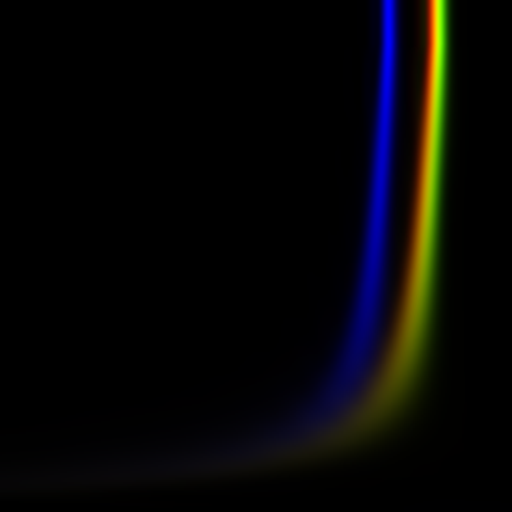

In [8]:
img = PIL.Image.open(files_good[0])
img

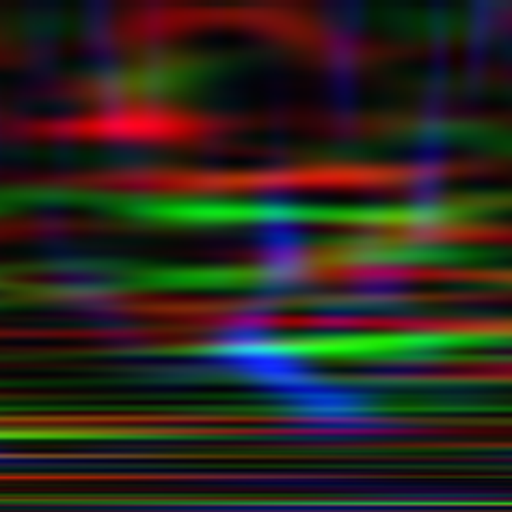

In [9]:
img = PIL.Image.open('../super resolution GW/data images/poluted/1683_28.6_29.4_1040_2.8501_3.9387_2.3146_0.1378.png')
img

### We can also check about the mode of the image (RGB, CYMK, ...)

In [10]:
img.mode

'RGB'

In [11]:
np.array(img).shape

(512, 512, 3)

### Lets define some steps to create our dataset:
- open an image which is good.
- open the correspondent crap image.
- the good images will be the CNN objective (target or y) while the crap images will be our inputs (x).
- convert both into tensors and normalize it.
- feed in our model.

we need first create a function to open the images for us and convert it to tensors:

In [12]:
def open_image(fname, size=224):
    img = PIL.Image.open(fname).convert('RGB')
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

### we have use the t.permute(2,0,1) due to the fact that PIL produces an array with dimensions $[W,H,C]$ while pytorch works with arrays of dimensions $[C,W,H]$. The float call converts the array entriesn into float points and finally we divide everything by 255.0, the maximum value of an array entry (pixel) can get.

In [14]:
open_image(files_good[0])

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [15]:
open_image(files_good[0]).shape

torch.Size([3, 224, 224])

### Ok, now we have to open the images correctly. When I created this dataset I kept the same name for both images (which is a bit dangerous, but I like to live on the edge) and store them in different folders. 

### we can create a function wich returns the first parameter of the images names, which correspond to the index order of the image.

In [16]:
files_crap[0].name

'1683_28.6_29.4_1040_2.8501_3.9387_2.3146_0.1378.png'

In [17]:
def find_name(fname):
    name = fname.name.split('_')[0]
    return name

### testing the function:

In [18]:
find_name(files_crap[0])

'1683'

so far so good, now we need to create a function that everytime we open a "crap" image, the correspondente good image. We can use the index of the image, since they are the same. we can create a dictionary where the keys are the indexes of the images and the values are the names of the crap images.

first, lets create a list with the indexes of all good images:

In [19]:
labels = list(set(files_good.map(find_name)))

Now we can create the dictionary where the keys are the images indexes and the values are the path to the correspondent "crap" images:

In [20]:
lbl2file = {l:[f for f in files_crap if f.name.split('_')[0] == l] for l in labels}

## List Comprehensions
List comprehensions provide a concise way to create lists. Common applications are to make new lists where each element is the result of some operations applied to each member of another sequence or iterable, or to create a subsequence of those elements that satisfy a certain condition.

In [21]:
squares = []
for x in range(10):
    squares.append(x**2)

squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

or (be lazy):

In [22]:
squares = [x**2 for x in range(10)]
squares

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

we can also create nested list comprehensions:

In [23]:
matrix = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
]

we can transpose such matrix:

In [24]:
[[row[i] for row in matrix] for i in range(4)]

[[1, 5, 9], [2, 6, 10], [3, 7, 11], [4, 8, 12]]

now we can create a function that get the index and returns the correspondent image

In [25]:
def draw_other(f):
    cls = find_name(f)
    return lbl2file[cls]

lets check if it works:

In [26]:
draw_other(files_good[10])

[Path('../super resolution GW/data images/poluted/635_6.8_20.6_776_1.3704_1.8666_-1.1499_4.3121.png')]

### We are almost there, now we can create a new function wich use everthing we create so far an return a tuple of the images (good, crap)

In [27]:
def get_tuple_files(path):
    files = get_image_files(path)
    return [[f, *draw_other(f)] for f in files]

before we create our dataset, its very convinient if we create a function to return our inputs and targets in the correct order for our task:

In [28]:
def get_x(t): return t[1]
def get_y(t): return t[0]

now we can create our dataset and dataloader using the DataBlock API:

In [29]:
DataBlock?

Init signature:
DataBlock(
    blocks=None,
    dl_type=None,
    getters=None,
    n_inp=None,
    item_tfms=None,
    batch_tfms=None,
    *,
    get_items=None,
    splitter=None,
    get_y=None,
    get_x=None,
)
Docstring:      Generic container to quickly build `Datasets` and `DataLoaders`
File:           ~/anaconda3/envs/fastai_v2/lib/python3.7/site-packages/fastai/data/block.py
Type:           type
Subclasses:     


In [31]:
dbt = DataBlock(
    blocks=(ImageBlock, ImageBlock),
    get_items=get_tuple_files,
    get_x=get_x, get_y=get_y,
    splitter=RandomSplitter(),
    item_tfms=Resize(128),
    batch_tfms=[Normalize.from_stats(*imagenet_stats),*aug_transforms(do_flip=False)]
)

### and now the dataloader

In [32]:
dls = dbt.dataloaders(path_good, bs=16)

### and check this:

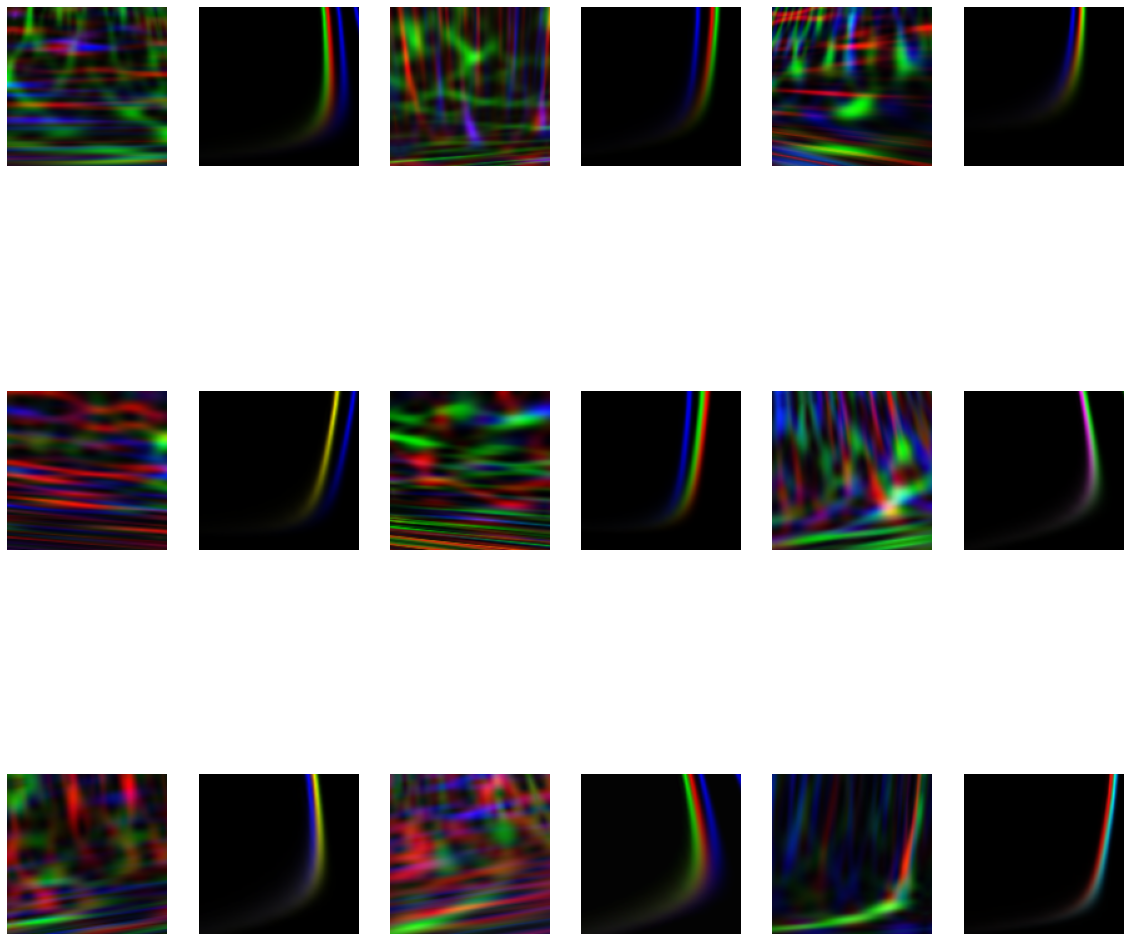

In [34]:
dls.show_batch(figsize=(20,20))

### Now we can create our CNN model. FastAI has been working in recent years towards making a range of models easier and faster to train, with a particular focus on using transfer learning. Transfer learning refers to pre-training a model using readily available data and quick and easy to calculate loss functions, and then fine-tuning that model for a task that may have fewer labels, or be more expensive to compute.

### We are going to use a ResNet34 as our base model and add a U-net upsampling network.

In [35]:
arch = resnet34

### FastAI has the unet_learner which we can use to setup our U-net model:

In [36]:
unet_learner?

Signature:
unet_learner(
    dls,
    arch,
    loss_func=None,
    pretrained=True,
    cut=None,
    splitter=None,
    config=None,
    n_in=3,
    n_out=None,
    normalize=True,
    opt_func=<function Adam at 0x7f2ed38da5f0>,
    lr=0.001,
    cbs=None,
    metrics=None,
    path=None,
    model_dir='models',
    wd=None,
    wd_bn_bias=False,
    train_bn=True,
    moms=(0.95, 0.85, 0.95),
)
Docstring: Build a unet learner from `dls` and `arch`
File:      ~/anaconda3/envs/fastai_v2/lib/python3.7/site-packages/fastai/vision/learner.py
Type:      function


In [37]:
b = dls.one_batch()

In [44]:
b[0].max()

TensorImage(2.6269, device='cuda:0')

In [45]:
uconf = unet_config(blur=True,norm_type=NormType.Weight, self_attention=True, y_range=(-2.2,2.8))

In [46]:
def create_gen_learner():
    return unet_learner(dls, arch, wd=1e-3, loss_func=MSELossFlat(), config=uconf)

In [47]:
dls.c = 3

In [48]:
learn_gen = create_gen_learner()

### Check if the model is works as intended:

In [49]:
learn_gen.summary()

DynamicUnet (Input shape: ['16 x 3 x 128 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 64 x 64 x 64    9,408      False     
________________________________________________________________
BatchNorm2d          16 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 16 x 64 x 64 x 64    0          False     
________________________________________________________________
MaxPool2d            16 x 64 x 32 x 32    0          False     
________________________________________________________________
Conv2d               16 x 64 x 32 x 32    36,864     False     
________________________________________________________________
BatchNorm2d          16 x 64 x 32 x 32    128        True      
________________________________________________________________
ReLU                 16 x 64 x 32 x 32    0          False     
________________________________________________

In [50]:
learn_gen.unfreeze()

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.00010964782268274575)

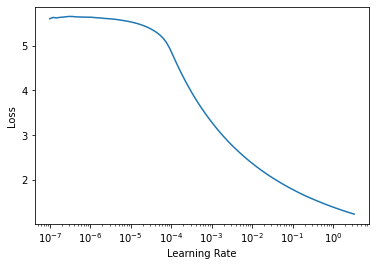

In [51]:
learn_gen.lr_find()

In [52]:
learn_gen.to_fp16()

In [53]:
learn_gen.fit_one_cycle(25, 0.00011,pct_start=0.8)

epoch,train_loss,valid_loss,time
0,3.485936,1.239051,00:26
1,0.745938,0.295597,00:22
2,0.363332,0.292874,00:22
3,0.306535,0.286181,00:22
4,0.261792,0.224496,00:22
5,0.206890,0.181098,00:23
6,0.154211,0.129973,00:23
7,0.131282,0.122911,00:22
8,0.122980,0.126059,00:23
9,0.120969,0.123614,00:23


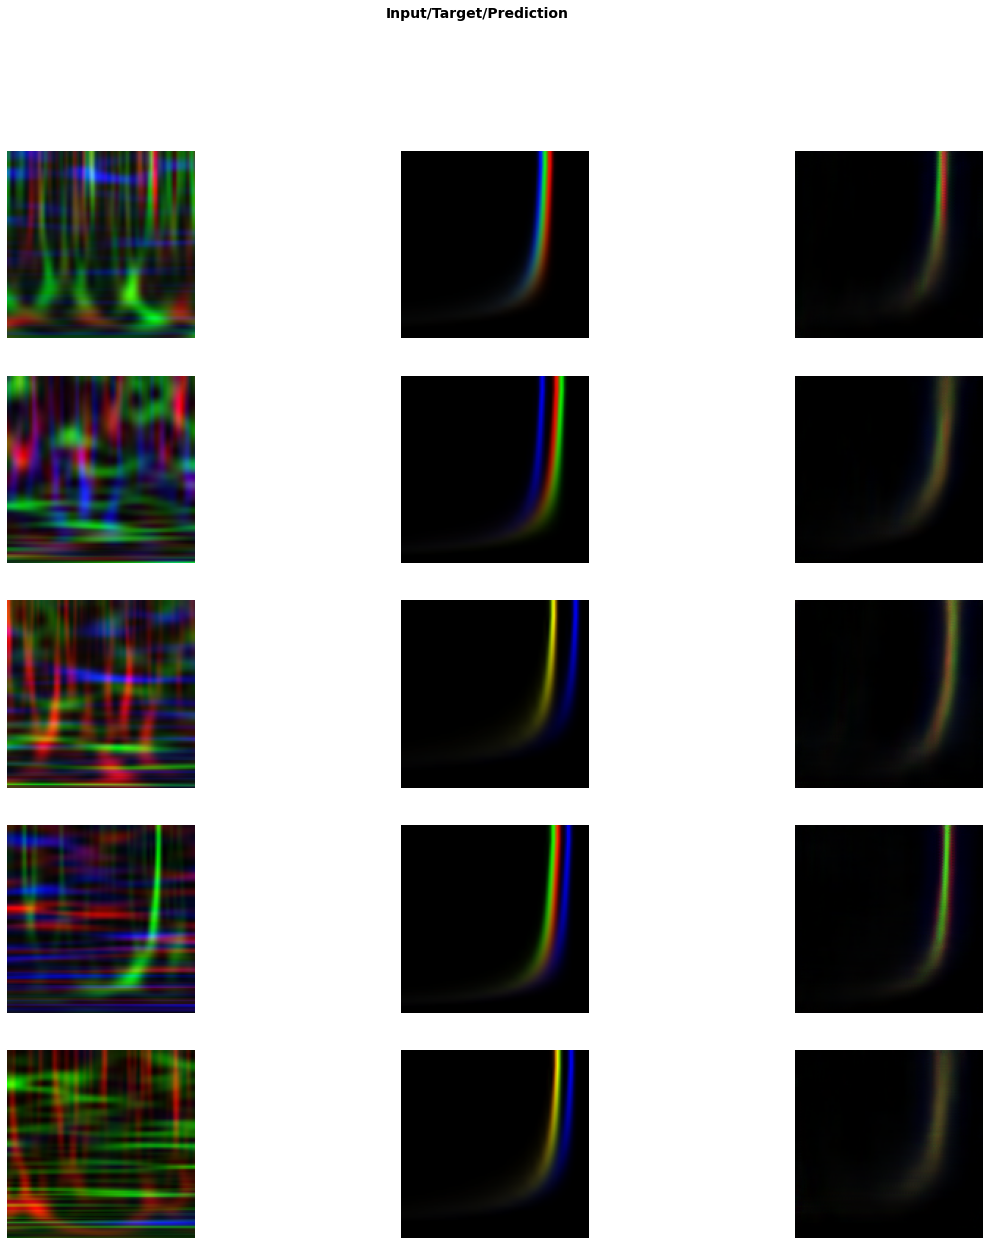

In [54]:
learn_gen.show_results(figsize=(20,20))

using our cool trick of using fine_tune, as we did before:

In [55]:
learn_gen.final_record

(#1) [0.10642143338918686]

SuggestedLRs(lr_min=9.999999747378752e-07, lr_steep=1.0964781722577754e-06)

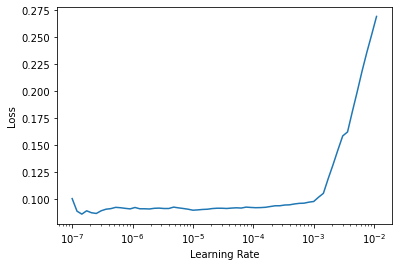

In [56]:
learn_gen.lr_find()

In [57]:
learn_gen.fine_tune(7,base_lr=1.096e-6)

epoch,train_loss,valid_loss,time
0,0.092150,0.112155,00:20


epoch,train_loss,valid_loss,time
0,0.090701,0.112135,00:22
1,0.090940,0.112206,00:22
2,0.091343,0.112411,00:22
3,0.093365,0.112225,00:22
4,0.093281,0.111792,00:22
5,0.092964,0.112345,00:22
6,0.092185,0.112215,00:22


In [58]:
learn_gen.to_fp32()

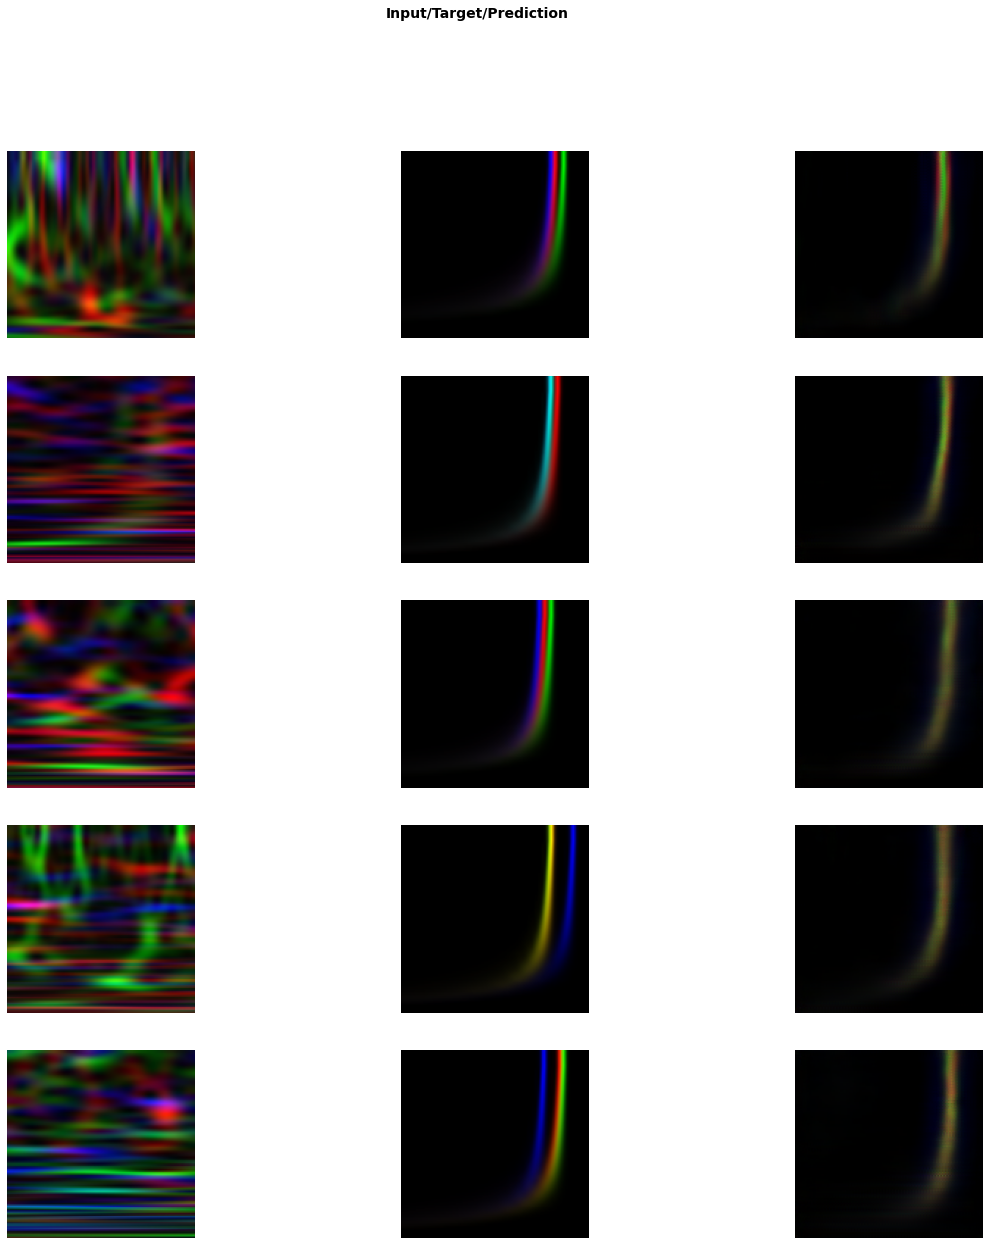

In [59]:
learn_gen.show_results(figsize=(20,20))

### We can test on some real data

In [60]:
path_real_data = Path('real_signals/')

In [61]:
real_files = get_image_files(path_real_data)

In [69]:
img = PILImage.create(real_files[15])
x, = first(dls.test_dl([img]))

In [73]:
x.shape

torch.Size([1, 3, 128, 128])

In [77]:
_,_,preds = learn_gen.get_preds(dl=[[x]], with_decoded=True)

In [92]:
tm = torch.nn.Softmax(dim=0)

<AxesSubplot:>

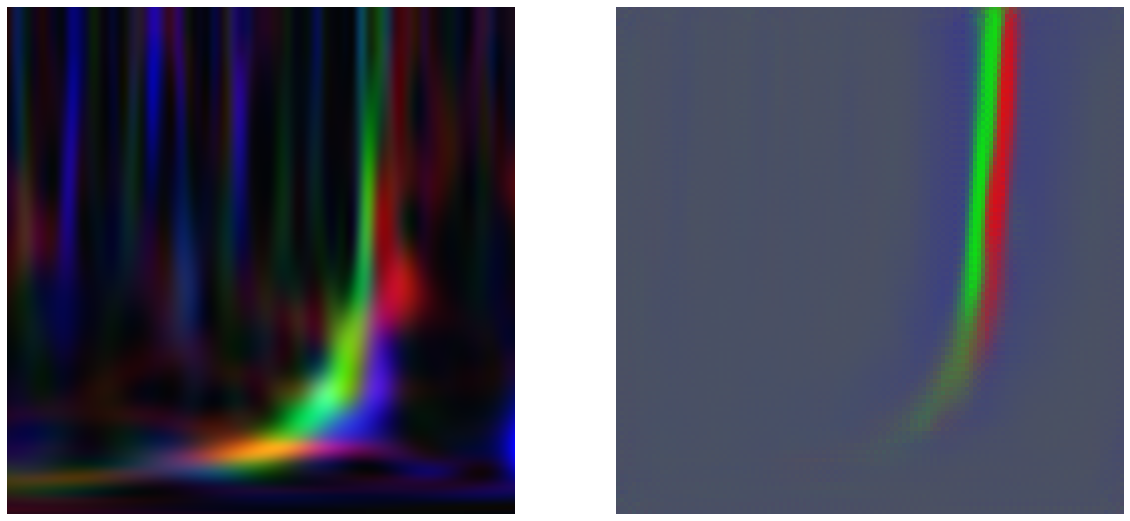

In [99]:
_, axs = plt.subplots(1,2,figsize=(20,12))
show_image((tm(preds[0])),ax=axs[1])
show_image(img,ax=axs[0])

<img src="./figs/gow.gif" style="width: 650px;" align="center"/>